In [54]:
import pandas as pd
import numpy as np
import os
from utils import *
from model import *
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error

### Prepare the data

In [11]:
train_B = pd.read_csv("../processed_data/train_B.csv")
test_B = pd.read_csv("../processed_data/test_B.csv")
train_R = pd.read_csv("../processed_data/train_R.csv")
test_R = pd.read_csv("../processed_data/test_R.csv")

In [14]:
train_RB = pd.concat([train_B, train_R])
test_RB = pd.concat([test_B, test_R])
train_RB = train_RB.sample(frac=1).reset_index(drop=True)
test_RB = test_RB.sample(frac=1).reset_index(drop=True)

In [18]:
sk_B = train_B.iloc[:, 0]/100
sk_R = train_R.iloc[:, 0]/100
sk_RB = train_RB.iloc[:, 0]/100

In [27]:
v_B = train_B.iloc[:, -1]
v_R = train_R.iloc[:, -1]
v_RB = train_RB.iloc[:, -1]

In [31]:
v_data = [v_R, v_B, v_RB]
sk_data = [sk_R, sk_B, sk_RB]
dataset_name = ['R', 'B', 'R+B']

### Fit the model

In [35]:
weidmann_params = []
for i in range(len(v_data)):
    # Initial guess for parameters (v0, l, T)
    initial_guess = (1.5, 0.6, 0.7)

    # Perform curve fitting
    params, covariance = curve_fit(
        weidmann_model, sk_data[i], v_data[i], p0=initial_guess)

    # Extract fitted parameters
    v0_fit, l_fit, T_fit = params

    # Print fitted parameters
    print(f"Fitted parameters for dataset {dataset_name[i]}:")
    print(f"v0 = {v0_fit}")
    print(f"l = {l_fit}")
    print(f"T = {T_fit}")

    weidmann_params.append([v0_fit, l_fit, T_fit])

Fitted parameters for dataset R:
v0 = 1.188443109749062
l = 0.6044718294392496
T = 0.9288191592602665
Fitted parameters for dataset B:
v0 = 1.5632935597047872
l = 0.5230372716649301
T = 0.6329054243625268
Fitted parameters for dataset R+B:
v0 = 1.1667406254770785
l = 0.5954860655848371
T = 0.7697956091840169


In [36]:
weidmann_params = pd.DataFrame(np.array(weidmann_params))

In [38]:
weidmann_params.columns = ['v0', 'l', 'T']

In [40]:
weidmann_params.to_csv('../outputs/weidmann_params.csv', index=False)

### Make predictions after fitting

In [41]:
# Input of the Weidmann model
X_B = test_B.iloc[:, 0]/100
X_R = test_R.iloc[:, 0]/100
X_RB = test_RB.iloc[:, 0]/100

In [52]:
# Label of the Weidmann model
Y_B = test_B.iloc[:, -1]
Y_R = test_R.iloc[:, -1]
Y_RB = test_RB.iloc[:, -1]

In [43]:
params_R = weidmann_params.iloc[0, :]
params_B = weidmann_params.iloc[1, :]
params_RB = weidmann_params.iloc[2, :]

In [53]:
model_params = [params_R, params_B, params_R,
                params_B, params_RB, params_RB, params_RB]
X_test = [X_R, X_B, X_B, X_R, X_R, X_B, X_RB]
Y_test = [Y_R, Y_B, Y_B, Y_R, Y_R, Y_B, Y_RB]
combination_name = ['R/R', 'B/B', 'R/B', 'B/R', 'R+B/R', 'R+B/B', 'R+B/R+B']

In [48]:
Y_preds = []
for i in range(len(combination_name)):
    Y_pred = weidmann_model(x=X_test[i], v0=model_params[i].iloc[0],
                            l=model_params[i].iloc[1], T=model_params[i].iloc[2])
    Y_preds.append(Y_pred)

In [49]:
Y_preds

[0         1.087109
 1         0.483990
 2         0.482600
 3         0.276660
 4         0.104615
             ...   
 408856    0.278152
 408857    0.195265
 408858    0.318333
 408859    0.598198
 408860    0.072715
 Name: 0, Length: 408861, dtype: float64,
 0         0.563833
 1         0.675813
 2         0.486401
 3         0.559911
 4         1.255481
             ...   
 125664    0.729530
 125665    0.386984
 125666    1.222177
 125667    1.194133
 125668    0.486052
 Name: 0, Length: 125669, dtype: float64,
 0         0.331637
 1         0.418204
 2         0.272371
 3         0.328624
 4         0.890299
             ...   
 125664    0.460126
 125665    0.196918
 125666    0.861541
 125667    0.837551
 125668    0.272105
 Name: 0, Length: 125669, dtype: float64,
 0         1.470949
 1         0.759950
 2         0.758182
 3         0.492025
 4         0.264174
             ...   
 408856    0.493980
 408857    0.384795
 408858    0.546503
 408859    0.903822
 408860    0.2

### Calculate MSE

In [59]:
weidmann_MSE = []
for i in range(len(Y_preds)):
    MSE = mean_squared_error(Y_test[i], Y_preds[i])
    weidmann_MSE.append(MSE)
    print(f"MSE for {combination_name[i]}: {MSE}")

MSE for R/R: 0.04823817585769993
MSE for B/B: 0.05145242191261933
MSE for R/B: 0.11574410655389654
MSE for B/R: 0.11167394785065124
MSE for R+B/R: 0.05180423440026487
MSE for R+B/B: 0.08786607661453122
MSE for R+B/R+B: 0.06028244076702565


In [62]:
combination_name

['R/R', 'B/B', 'R/B', 'B/R', 'R+B/R', 'R+B/B', 'R+B/R+B']

In [64]:
np.array(weidmann_MSE)

array([0.04823818, 0.05145242, 0.11574411, 0.11167395, 0.05180423,
       0.08786608, 0.06028244])

In [67]:
weidmann_MSE = pd.DataFrame(
    np.array(weidmann_MSE).reshape(1, -1), columns=combination_name)

In [68]:
weidmann_MSE

,R/R,B/B,R/B,B/R,R+B/R,R+B/B,R+B/R+B
0,0.048238,0.051452,0.115744,0.111674,0.051804,0.087866,0.060282


In [70]:
weidmann_MSE.to_csv('../outputs/weidmann_MSE.csv', index=False)

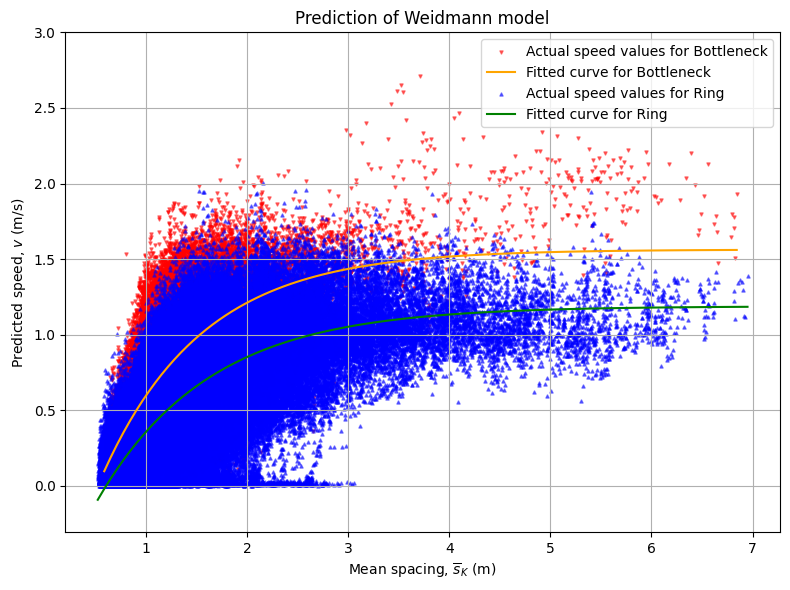

In [73]:
# Generate smooth curve based on fitted parameters
sk_smooth_B = np.linspace(min(X_B), max(X_B), 100)
v_smooth_B = weidmann_model(
    sk_smooth_B, params_B.iloc[0], params_B.iloc[1], params_B.iloc[2])

sk_smooth_R = np.linspace(min(X_R), max(X_R), 100)
v_smooth_R = weidmann_model(
    sk_smooth_R, params_R.iloc[0], params_R.iloc[1], params_R.iloc[2])

# Plotting the original data and fitted curve
plt.figure(figsize=(8, 6))
plt.scatter(X_B, Y_B, s=5, c='red', alpha=0.5,
            marker='v', label='Actual speed values for Bottleneck')
plt.plot(sk_smooth_B, v_smooth_B, c='orange',
         alpha=1, label='Fitted curve for Bottleneck')

plt.scatter(X_R, Y_R, s=5, c='blue', alpha=0.5,
            marker='^', label='Actual speed values for Ring')
plt.plot(sk_smooth_R, v_smooth_R, c='green',
         alpha=1, label='Fitted curve for Ring')
plt.ylim(top=3)
plt.title('Prediction of Weidmann model')
plt.xlabel('Mean spacing, $\overline{s}_K$ (m)')
plt.ylabel('Predicted speed, $v$ (m/s)')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()